In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

np.random.seed(123)
torch.manual_seed(123)

# Use some real data - Jiang et al

In [2]:
x = torch.from_numpy(
    np.load("../../hydro-interpretive-dl/jiang_et_al_xtrain.npy")
).float()
y = torch.from_numpy(
    np.load("../../hydro-interpretive-dl/jiang_et_al_ytrain.npy")
).float()

x = x[:100]
y = y[:100]

x.shape, y.shape

(torch.Size([100, 180, 2]), torch.Size([100, 1]))

# Define a simple model

In [3]:
import torch
import torch.nn as nn


# Simple LSTM made from scratch
class LSTMDA(nn.Module):
    def __init__(self, input_dim, hidden_dim, recur_dropout = 0, dropout = 0):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_size = hidden_dim
        # See the file "neuralnet_math_README.md" in the root directory for
        # equations and implementation details
        self.weight_ih = nn.Parameter(torch.Tensor(input_dim, hidden_dim * 4))
        self.weight_hh = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_dim * 4))
        self.init_weights()
        
        self.dropout = nn.Dropout(dropout)
        self.recur_dropout = nn.Dropout(recur_dropout)
        
        self.dense = nn.Linear(hidden_dim, 1, bias = False)
    
    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
        
    def forward(self, x, init_states = None):
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _ = x.size()
        f_seq = []
        o_seq = []
        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device), 
                        torch.zeros(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states
        
        x = self.dropout(x)
        HS = self.hidden_size
        for t in range(seq_sz):
            x_t = x[:, t, :]
            # batch the computations into a single matrix multiplication
            gates = x_t @ self.weight_ih + h_t @ self.weight_hh + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]), # input
                torch.sigmoid(gates[:, HS:HS*2]), # forget
                torch.tanh(gates[:, HS*2:HS*3]),
                torch.sigmoid(gates[:, HS*3:]), # output
            )
            c_t = f_t * c_t + i_t * self.recur_dropout(g_t)
            h_t = o_t * torch.tanh(c_t)
            f_seq.append(f_t.unsqueeze(1))
            o_seq.append(o_t.unsqueeze(1))
            hidden_seq.append(h_t.unsqueeze(1))
        f_seq = torch.cat(f_seq, dim=1)
        o_seq = torch.cat(o_seq, dim=1)
        hidden_seq = torch.cat(hidden_seq, dim= 1)
        out = self.dense(hidden_seq)
        return out, (f_seq, o_seq, hidden_seq) # changed, dont return states

model = LSTMDA(2, 16)

In [4]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

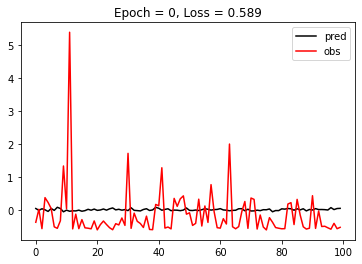

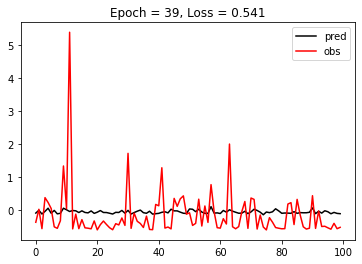

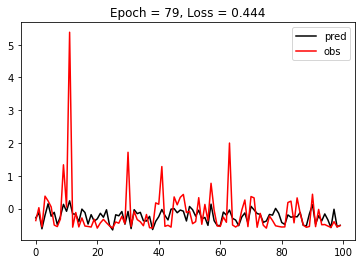

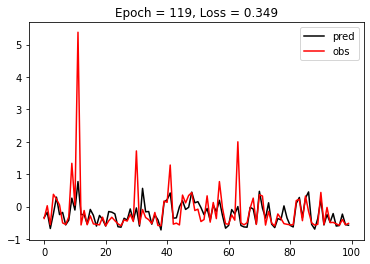

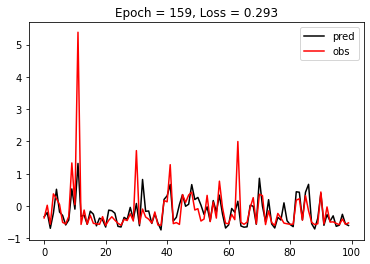

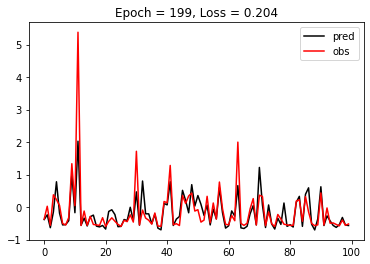

In [5]:
for i in range(200):
    out, (f_ls, o_ls, h_ls) = model(x)
    out = out[:, -1, :] # unlike Jiang et al's orginal, here the dense layer acts on whole LSTM seq output
    loss = loss_fn(out, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % 40 == 0 or i == 0:
        plt.plot(out.detach(), color = 'black', label = 'pred')
        plt.plot(y, color = 'red', label = 'obs')
        plt.title('Epoch = ' + str(i) + ', Loss = ' + str(np.round(loss.item(), 3)))
        plt.legend()
        plt.show()
        plt.pause(0.001)

# Apply XAI and visualize

In [6]:
f_ls = f_ls.detach()
o_ls = o_ls.detach()
h_ls = h_ls.detach()

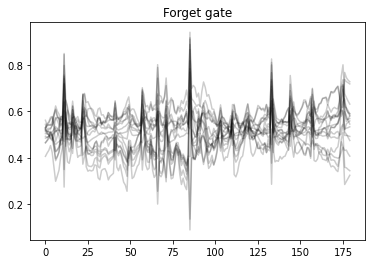

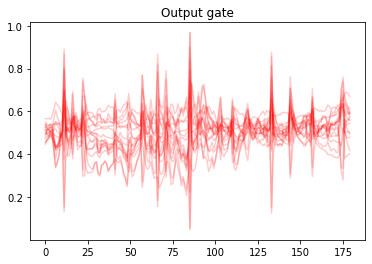

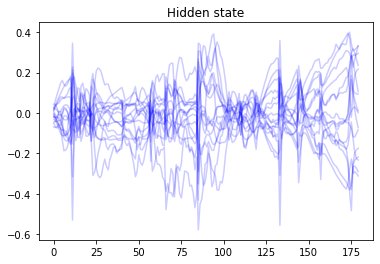

In [7]:
plt.plot(f_ls[0, :], color = 'black', alpha = 0.2)
plt.title('Forget gate')
plt.pause(0.001)
plt.plot(o_ls[0, :], color = 'red', alpha = 0.2)
plt.title('Output gate')
plt.pause(0.001)
plt.plot(h_ls[0, :], color = 'blue', alpha = 0.2)
plt.title('Hidden state');

In [8]:
h_T = torch.zeros_like(h_ls)

prop_retained_T = torch.zeros_like(h_ls)
info_gained_T = torch.zeros_like(h_ls)
info_contributed_T = torch.zeros((h_ls.shape[0], h_ls.shape[1], 1))

for t in range(1, h_T.shape[1]):
    
    # Product for retention from k = t+1 to T
    for k in range(t+1, h_T.shape[1]):
        # f_{k} * o_{k} / o_{k-1}
        value = (f_ls[:, [k]]*o_ls[:, [k]]) / o_ls[:, [k-1]]
        if k == t+1:
            proportion_retained = value
        else:
            proportion_retained = value*proportion_retained
    prop_retained_T[:, [t], :] = proportion_retained
    
    # Equations for initial gain
    # intermed_value = f_{t} * o_{t} / o_{t-1}]
    intermed_value = (f_ls[:, [t]]*o_ls[:, [t]]) / o_ls[:, [t-1]]
    # h_{t} - value * h_{t-1}
    info_gained = h_ls[:, [t]] - (intermed_value*h_ls[:, [t-1]])
    info_gained_T[:, [t], :] = info_gained
    
    # Summation for actual contribution
    last_value = proportion_retained*info_gained
    if t == 1:
        info_contributed = last_value
    else:
        info_contributed = info_contributed + last_value
        
    # Application of weight matrix
    for batch_i in range(h_ls.shape[0]):
        with torch.no_grad():
            info_contributed_T[batch_i, t, 0] = nn.functional.linear(info_contributed[batch_i],
                                                                     model.dense.weight)

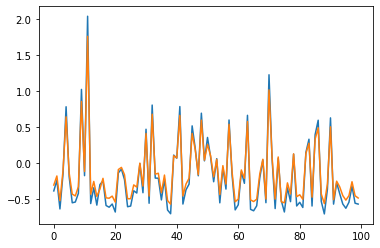

In [9]:
plt.plot(nn.functional.linear(h_ls[:, -1], model.dense.weight).detach()) # h_{t} times the dense layers weights
plt.plot(info_contributed_T[:, -1]); # information gain = h_{t}, times the dense layer weights

*NOTE:* This method is an approximation so it won't recreate exactly, but it almost does

# Same plots looking at different sequences

In [10]:
def plot_paper_figures(batch_i):
    fig, ax = plt.subplots(4, 2, figsize = (12, 16))
    
    ax[0, 0].plot(x[batch_i])
    ax[0, 0].set_title('Data')
    ax[0, 0].scatter(180, y[batch_i], color = 'Red', marker = 'x', label = 'Observation')
    ax[0, 0].scatter(180, out[batch_i].detach(), color = 'Black', marker = 'x', label = 'Prediction')
    ax[0, 0].legend()
    ax[0,1].set_visible(False)

    ax[1, 0].plot(info_gained_T[batch_i], color = 'black', alpha = 0.1)
    ax[1, 0].set_title('Information initially gained')
    ax[1, 1].plot(info_gained_T[batch_i, -25:], color = 'black', alpha = 0.1)
    ax[1, 1].set_title('Information initially gained | last 25 observations')

    ax[2, 0].plot(prop_retained_T[batch_i], color = 'black', alpha = 0.1)
    ax[2, 0].set_title('Proportion to be retained')
    ax[2, 1].plot(prop_retained_T[batch_i, -25:], color = 'black', alpha = 0.1)
    ax[2, 1].set_title('Proportion to be retained | last 25 observations')

    ax[3, 0].bar(range(info_contributed_T[batch_i].shape[0]),
                 info_contributed_T[batch_i],
                 color = 'red', edgecolor = 'black')
    ax[3, 0].set_title('Information actually contributed')
    ax[3, 1].bar(range(info_contributed_T[batch_i, -25:].shape[0]),
                 info_contributed_T[batch_i, -25:],
                 color = 'red', edgecolor = 'black')
    ax[3, 1].set_title('Information actually contributed | last 25 observations');

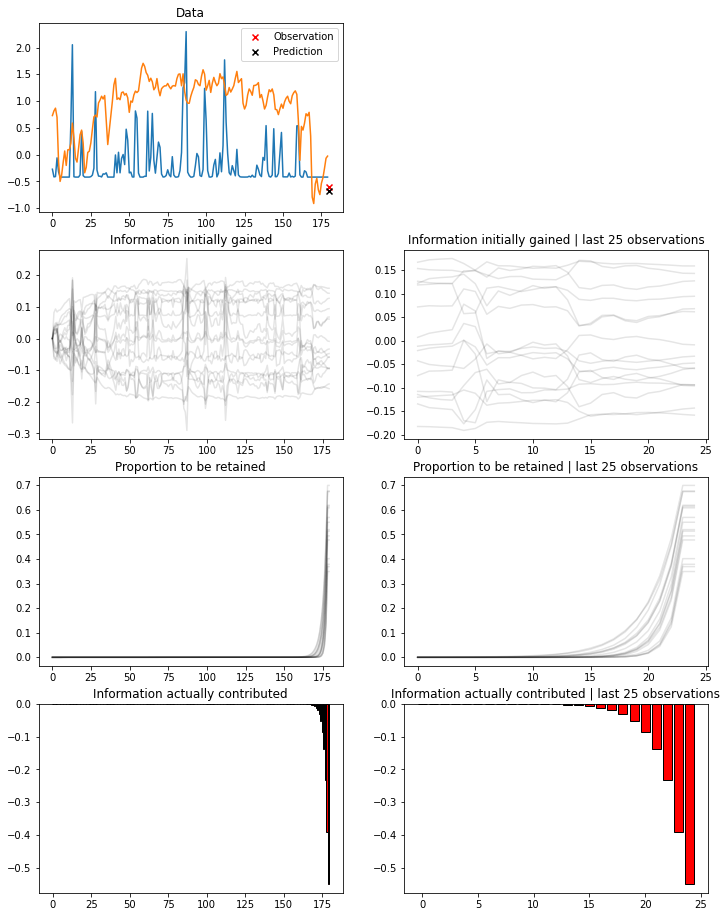

In [11]:
batch_i = 75 # lowest observation
plot_paper_figures(batch_i)

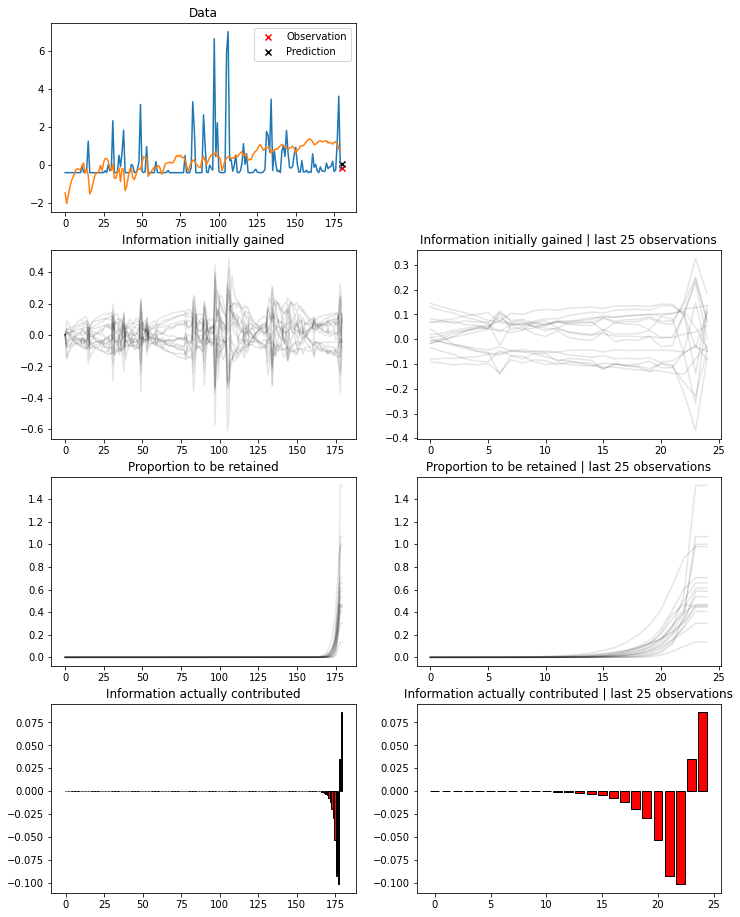

In [12]:
batch_i = 73 # average observation
plot_paper_figures(batch_i)

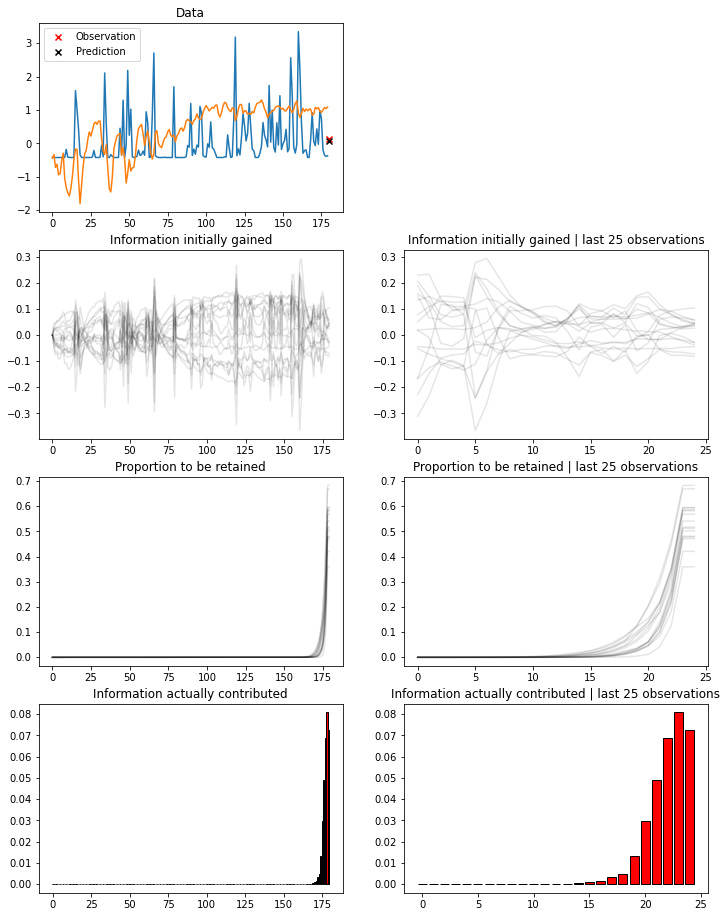

In [13]:
batch_i = 40 # above average observation
plot_paper_figures(batch_i)

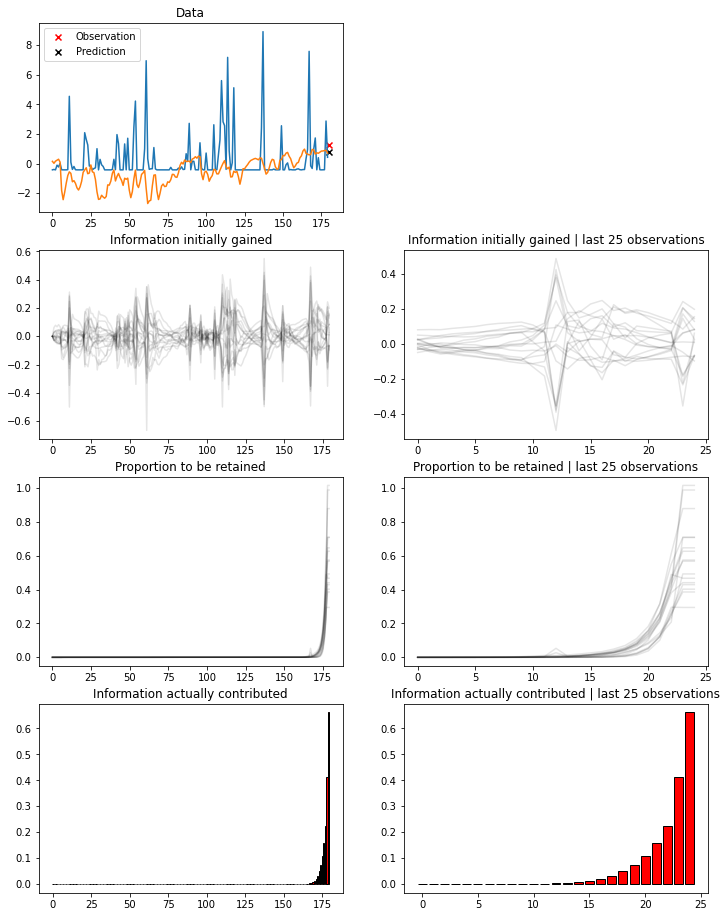

In [14]:
batch_i = 41 # high observation
plot_paper_figures(batch_i)

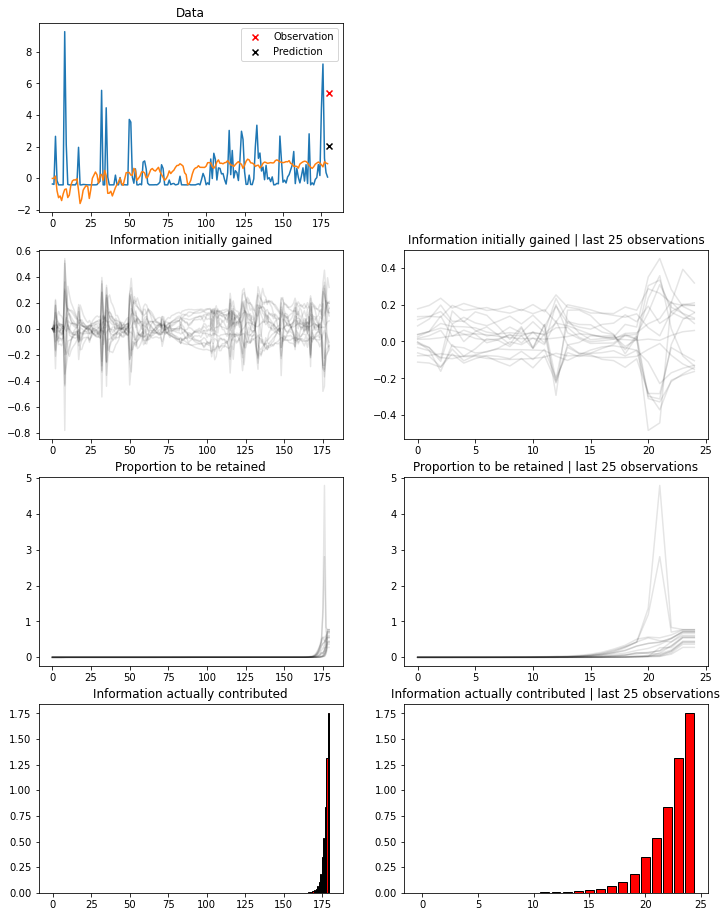

In [15]:
batch_i = 11 # highest observation
plot_paper_figures(batch_i)